# Segmentation: KNN

Our aim in this notebook is to segment a Planet image into crop/non-crop regions. We first classify the pixels as crop/non-crop then segment the classified result.

NOTE: Currently, this notebook implements classification, segmentation is still in-progress.

K-nearest neighbors (KNN) is a supervised learning technique for classification. It is a straightforward machine-learning algorithm. See [wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) for more details. In this notebook, we use KNN Classification to classify pixels as crop / non-crop based on their red, green, blue, and NIR band top-of-atmosphere (TOA) reflectance values.

TOA reflectance is not affected by the satellite that takes the image, the time of day, or the time of year. It is affected by atmosphere, which isn't ideal. However, correcting for the atmosphere is complicated, requires detailed input data, and is error-prone. Therefore, TOA reflectance is the dataset we are going to use. The Planet product we use has the bands scaled to TOA radiance. We use the radiance coefficient, stored in the product metadata, to scale bands to TOA reflectance.

The data used in this notebook is selected and described in the [Identify Datasets](datasets-identify.ipynb) notebook and prepared in the [Prepare Datasets](datasets-prepare.ipynb) notebook. Survey data from 2015 is used as the 'ground truth' for training the KNN Classifier and assessing accuracy. The Planet imagery used in this notebook was collected in 2017, so we expect there to be some inaccuracies in the ground truth data due to the 2-year gap. However, we don't expect a large difference in the crop/non-crop status of regions, so expect reasonable accuracy.

In [1]:
# Notebook dependencies
from __future__ import print_function

from collections import namedtuple
import copy
from functools import partial
import json
import os
from xml.dom import minidom

import cv2
import ipyleaflet as ipyl
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import rasterio
from shapely.geometry import mapping, shape, Polygon
from shapely.ops import transform
from sklearn import neighbors
from sklearn.metrics import classification_report

%matplotlib inline

### Input Data

We define the datasets to use for training the KNN classifier and testing the classifier. The training dataset will actually come from the 'test' folder, the test dataset will come from the 'train' folder. The reason for this swap is because the dataset in the 'train' folder is mostly composed of 'crop' regions while the datasets in the 'test' folder are composed of an approximately equal representation of 'crop' and 'non-crop' regions. Swapping these datasets results in an improvement in the classifier f-score on the test dataset of almost 10% (from 0.68 to 0.77 in the trial run).

In [2]:
# Train data
train_data_folder = os.path.join('data', 'test')

# Created in datasets-identify notebook
train_pl_metadata_filename = os.path.join(train_data_folder, '20160831_180257_0e26_3B_AnalyticMS_metadata.xml')
assert os.path.isfile(train_pl_metadata_filename)

# Created in datasets-prepare notebook
train_pl_filename = os.path.join(train_data_folder, '20160831_180257_0e26_3B_AnalyticMS_cropped.tif')
assert os.path.isfile(train_pl_filename)

train_ground_truth_filename = os.path.join(train_data_folder, 'ground-truth_cropped.geojson')
assert os.path.isfile(train_ground_truth_filename)

In [3]:
# Test data
test_data_folder = os.path.join('data', 'train')

# Created in datasets-identify notebook
test_pl_metadata_filename = os.path.join(test_data_folder, '20160831_180231_0e0e_3B_AnalyticMS_metadata.xml')
assert os.path.isfile(test_pl_metadata_filename)

# Created in datasets-prepare notebook
test_pl_filename = os.path.join(test_data_folder, '20160831_180231_0e0e_3B_AnalyticMS_cropped.tif')
assert os.path.isfile(test_pl_filename)

test_ground_truth_filename = os.path.join(test_data_folder, 'ground-truth_cropped.geojson')
assert os.path.isfile(test_ground_truth_filename)

## KNN Classification

Steps:
1. Training KNN Classifier
 - load and convert ground truth data to contours
 - load image and convert to reflectance
 - use contours to get crop / non-crop pixels
 - use crop / non-crop pixels as knn train  
2. Testing KNN Classifier
 - predict crop / non-crop pixels on same image
 - predict crop / non-crop pixels on train image

### Train Classifier

To train the KNN classifier, we need to identify the class of each pixel as either 'crop' or 'non-crop'. The class is determined from whether the pixel is associated with a crop feature in the ground truth data. To make this determination, we must first convert the ground truth data into OpenCV contours, then we use these contours to separate 'crop' from 'non-crop' pixels. The pixel values and their classification are then used to train the KNN classifier.

#### Features to Contours

To convert the ground truth features to contours, we must first project the features to the coordinate reference system of the image, transform the features into image space, and finally convert the features in image space to contours.

In [4]:
# Utility functions: features to contours

def project_feature(feature, proj_fcn):
    """Creates a projected copy of the feature.
    
    :param feature: geojson description of feature to be projected
    :param proj_fcn: partial function defining projection transform"""
    g1 = shape(feature['geometry'])
    g2 = transform(proj_fcn, g1)
    proj_feat = copy.deepcopy(feature)
    proj_feat['geometry'] = mapping(g2)
    return proj_feat


def project_features_to_srs(features, img_srs, src_srs='epsg:4326'):
    """Project features to img_srs.
    
    If src_srs is not specified, WGS84 (only geojson-supported crs) is assumed.
    
    :param features: list of geojson features to be projected
    :param str img_srs: destination spatial reference system
    :param str src_srs: source spatial reference system
    """
    # define projection
    # from shapely [docs](http://toblerity.org/shapely/manual.html#shapely.ops.transform)
    proj_fcn = partial(
        pyproj.transform,
        pyproj.Proj(init=src_srs),
        pyproj.Proj(init=img_srs))
    
    return [project_feature(f, proj_fcn) for f in features]


def polygon_to_contour(feature_geometry, image_transform):
    """Convert the exterior ring of a geojson Polygon feature to an
    OpenCV contour.
    
    image_transform is typically obtained from `img.transform` where 
    img is obtained from `rasterio.open()
    
    :param feature_geometry: the 'geometry' entry in a geojson feature
    :param rasterio.Affine image_transform: image transformation"""
    points_xy = shape(feature_geometry).exterior.coords
    points_x, points_y = zip(*points_xy) # inverse of zip
    rows, cols = rasterio.transform.rowcol(image_transform, points_x, points_y)
    return np.array([pnt for pnt in zip(cols, rows)], dtype=np.int32)

In [5]:
def load_geojson(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [6]:
def load_contours(ground_truth_filename, pl_filename):
    with rasterio.open(pl_filename) as img:
        img_transform = img.transform
        img_srs = img.crs['init']

    ground_truth_data = load_geojson(ground_truth_filename)

    # project to image srs
    projected_features = project_features_to_srs(ground_truth_data, img_srs)

    # convert projected features to contours
    contours = [polygon_to_contour(f['geometry'], img_transform)
                for f in projected_features]
    return contours

print(len(load_contours(train_ground_truth_filename, train_pl_filename)))

340


#### Visualize Contours over Image

To ensure our contours are accurate, we will visualize them overlayed on the image.

In [7]:
# Utility functions: loading an image

NamedBands = namedtuple('NamedBands', 'b, g, r, nir')

def load_bands(filename):
    """Loads a 4-band BGRNir Planet Image file as a list of masked bands.
    
    The masked bands share the same mask, so editing one band mask will
    edit them all."""
    with rasterio.open(filename) as src:
        b, g, r, nir = src.read()
        mask = src.read_masks(1) == 0 # 0 value means the pixel is masked
    
    bands = NamedBands(b=b, g=g, r=r, nir=nir)
    return NamedBands(*[np.ma.array(b, mask=mask)
                        for b in bands])

def get_rgb(named_bands):
    return [named_bands.r, named_bands.g, named_bands.b]

def check_mask(band):
    return '{}/{} masked'.format(band.mask.sum(), band.mask.size)
    
print(check_mask(load_bands(train_pl_filename).r))

177547/4913274 masked


In [8]:
# Utility functions: converting an image to reflectance

NamedCoefficients = namedtuple('NamedCoefficients', 'b, g, r, nir')

def read_refl_coefficients(metadata_filename):
    # https://github.com/planetlabs/notebooks/blob/master/jupyter-notebooks/ndvi/ndvi_planetscope.ipynb
    xmldoc = minidom.parse(metadata_filename)
    nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

    # XML parser refers to bands by numbers 1-4
    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)
    return NamedCoefficients(b=coeffs[1],
                             g=coeffs[2],
                             r=coeffs[3],
                             nir=coeffs[4])


def to_reflectance(bands, coeffs):
    return NamedBands(*[b.astype(float)*c for b,c in zip(bands, coeffs)])


def load_refl_bands(filename, metadata_filename):
    bands = load_bands(filename)
    coeffs = read_refl_coefficients(metadata_filename)
    return to_reflectance(bands, coeffs)


print(read_refl_coefficients(train_pl_metadata_filename))

NamedCoefficients(b=2.18308670475e-05, g=2.30150151806e-05, r=2.56590819374e-05, nir=3.8835539237e-05)


In [9]:
# Utility functions: displaying an image

def _linear_scale(ndarray, old_min, old_max, new_min, new_max):
    """Linear scale from old_min to new_min, old_max to new_max.
    
    Values below min/max are allowed in input and output.
    Min/Max values are two data points that are used in the linear scaling.
    """
    #https://en.wikipedia.org/wiki/Normalization_(image_processing)
    return (ndarray - old_min)*(new_max - new_min)/(old_max - old_min) + new_min
# print(linear_scale(np.array([1,2,10,100,256,2560, 2660]), 2, 2560, 0, 256))

def _mask_to_alpha(bands):
#     band = np.atleast_3d(bands)[...,0]
    band = np.atleast_3d(bands[0])
    alpha = np.zeros_like(band)
    alpha[~band.mask] = 1
    return alpha

def _add_alpha_mask(bands):
    return np.dstack([bands, _mask_to_alpha(bands)])

def bands_to_display(bands, alpha=False):
    """Converts a list of 3 bands to a 3-band rgb, normalized array for display."""  
    assert len(bands) in [1,3]
    all_bands = np.dstack(bands)
    old_min = np.percentile(all_bands, 2)
    old_max = np.percentile(all_bands, 98)

    new_min = 0
    new_max = 1
    scaled = [np.clip(_linear_scale(b.astype(np.double),
                                    old_min, old_max, new_min, new_max),
                      new_min, new_max)
              for b in bands]

    filled = [b.filled(fill_value=new_min) for b in scaled]
    if alpha:
        filled.append(_mask_to_alpha(scaled))

    return np.dstack(filled)

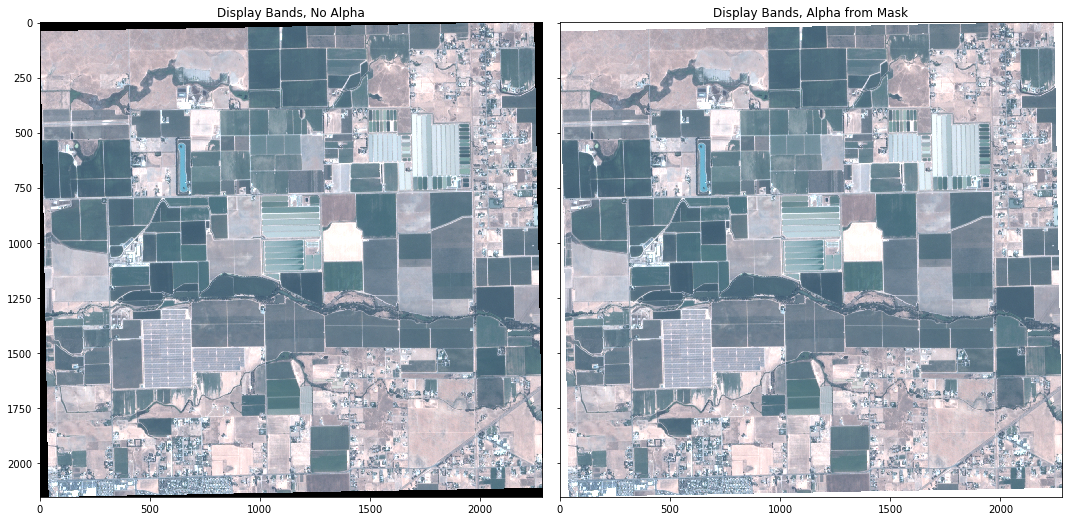

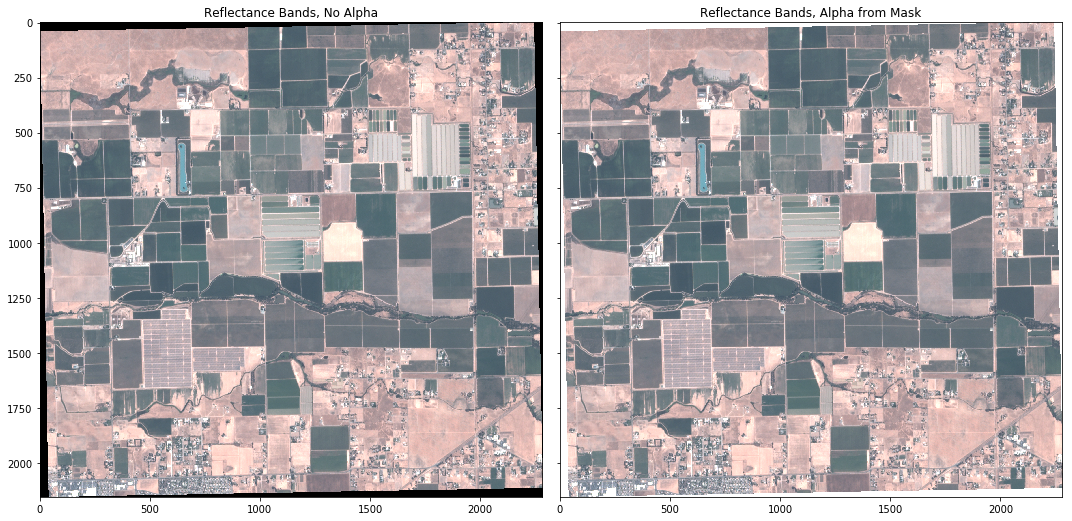

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,15))
for ax in (ax1, ax2):
    ax.set_adjustable('box-forced')

ax1.imshow(bands_to_display(get_rgb(load_bands(train_pl_filename)), alpha=False))
ax1.set_title('Display Bands, No Alpha')

ax2.imshow(bands_to_display(get_rgb(load_bands(train_pl_filename)), alpha=True))
ax2.set_title('Display Bands, Alpha from Mask')
plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,15))
for ax in (ax1, ax2):
    ax.set_adjustable('box-forced')
    
ax1.imshow(bands_to_display(get_rgb(load_refl_bands(train_pl_filename, train_pl_metadata_filename)), alpha=False))
ax1.set_title('Reflectance Bands, No Alpha')

ax2.imshow(bands_to_display(get_rgb(load_refl_bands(train_pl_filename, train_pl_metadata_filename)), alpha=True))
ax2.set_title('Reflectance Bands, Alpha from Mask')
plt.tight_layout()

In [11]:
# Utility functions: displaying contours

def draw_contours(img, contours, color=(0, 1, 0), thickness=2):
    """Draw contours over a copy of the image"""
    n_img = img.copy()
    # http://docs.opencv.org/2.4.2/modules/core/doc/drawing_functions.html#drawcontours
    cv2.drawContours(n_img,contours,-1,color,thickness=thickness)
    return n_img

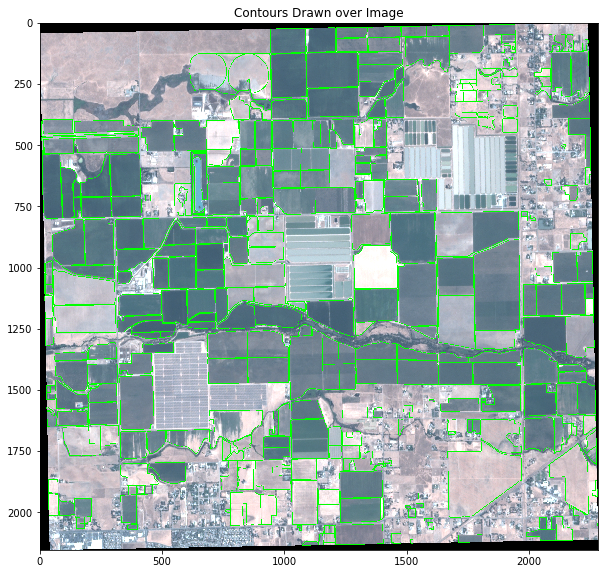

In [12]:
plt.figure(1, figsize=(10,10))
plt.imshow(draw_contours(bands_to_display(get_rgb(load_bands(train_pl_filename)), alpha=False),
                         load_contours(train_ground_truth_filename, train_pl_filename)))
_ = plt.title('Contours Drawn over Image')

#### Separate Crop and Non-Crop Pixels

To train the knn classifier, we need to separate crop from non-crop pixels. We will do this by using the crop feature contours to mask the crop or non-crop pixels.

In [13]:
# Utility functions: masking pixels using contours

def _create_contour_mask(contours, shape):
    """Masks out all pixels that are not within a contour"""
    mask = np.zeros(shape, dtype=np.uint8)
    cv2.drawContours(mask, contours, -1, (1), thickness=-1)
    return mask < 1

def combine_masks(masks):
    """Masks any pixel that is masked in any mask.
    
    masks is a list of masks, all the same size"""
    return np.any(np.dstack(masks), 2)

def _add_mask(bands, mask):
    # since band masks are linked, could use any band here
    bands[0].mask = combine_masks([bands[0].mask, mask])

def mask_contours(bands, contours, in_contours=False):
    contour_mask = _create_contour_mask(contours, bands[0].mask.shape)
    if in_contours:
        contour_mask = ~contour_mask
    _add_mask(bands, contour_mask)
    return bands

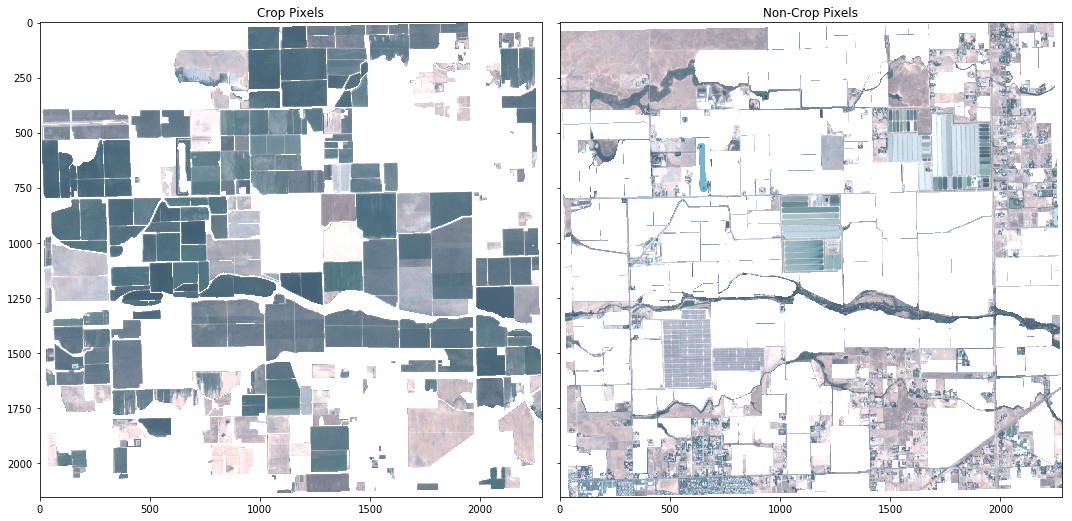

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,15))
for ax in (ax1, ax2):
    ax.set_adjustable('box-forced')

ax1.imshow(bands_to_display(get_rgb(mask_contours(load_bands(train_pl_filename),
                                                  load_contours(train_ground_truth_filename,
                                                                train_pl_filename))),
                            alpha=True))
ax1.set_title('Crop Pixels')

ax2.imshow(bands_to_display(get_rgb(mask_contours(load_bands(train_pl_filename),
                                                  load_contours(train_ground_truth_filename,
                                                                train_pl_filename),
                                                  in_contours=True)),
                            alpha=True))
ax2.set_title('Non-Crop Pixels')
plt.tight_layout()

#### Fit the classifier

We use the scikit-learn [KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) to perform KNN classification.

KNeighborsClassifier fit input is two datasets: X, a 2d array that provides the features to be classified on, and y, a 1d array that provides the classes. X and y are ordered along the first dimension ([example](http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py)).

We first take the non-crop and crop datasets above and create a single classified band, where the values of the band indicate the pixel class.

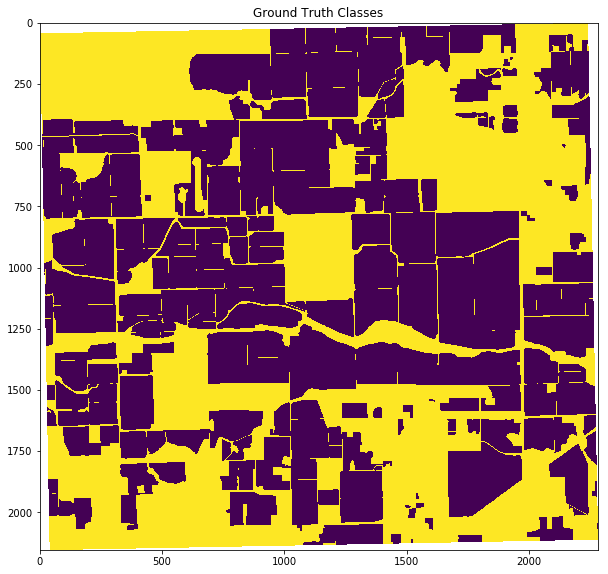

In [15]:
def classified_band_from_masks(band_mask, class_masks):
    class_band = np.zeros(band_mask.shape, dtype=np.uint8)

    for i, mask in enumerate(class_masks):
        class_band[~mask] = i

    # turn into masked array, using band_mask as mask
    return np.ma.array(class_band, mask=band_mask)


def create_contour_classified_band(pl_filename, ground_truth_filename):
    band_mask = load_bands(pl_filename)[0].mask
    contour_mask = _create_contour_mask(load_contours(ground_truth_filename, pl_filename),
                                        band_mask.shape)
    return classified_band_from_masks(band_mask, [contour_mask, ~contour_mask])

plt.figure(1, figsize=(10,10))
plt.imshow(create_contour_classified_band(train_pl_filename, train_ground_truth_filename))
_ = plt.title('Ground Truth Classes')

Next we convert this band and the underlying image pixel band values to the X and y inputs to the classifier fit function. Using these as inputs, we fit the classifier.

In [16]:
def to_X(bands):
    """Convert to a list of pixel values, maintaining order and filtering out masked pixels."""
    return np.stack([b.compressed() for b in bands], axis=1)

def to_y(classified_band):
    return classified_band.compressed()

In [17]:
def fit_classifier(pl_filename, ground_truth_filename, metadata_filename):
    n_neighbors = 15
    weights = 'uniform'
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    
    train_class_band = create_contour_classified_band(pl_filename, ground_truth_filename)
    X = to_X(load_refl_bands(pl_filename, metadata_filename))
    y = to_y(train_class_band)
    clf.fit(X, y)
    return clf

clf = fit_classifier(train_pl_filename, train_ground_truth_filename, train_pl_metadata_filename)

#### Test Fit on Train Data

To see how well the classifier works on its own input data, we use the classifier to predict the class of pixels using just the pixel band values. How well the classifier performs is based mostly on (1) the accuracy of the train data and (2) clear separation of the pixel classes based on the input data (pixel band values). The classifier parameters (number of neighbors, distance weighting function) can be tweaked to overcome weaknesses in (2).

In [18]:
def classified_band_from_y(band_mask, y):
    class_band = np.ma.array(np.zeros(band_mask.shape),
                             mask=band_mask.copy())
    class_band[~class_band.mask] = y
    return class_band


def predict(pl_filename, metadata_filename, clf):
    bands = load_refl_bands(pl_filename, metadata_filename)
    X = to_X(bands)

    y = clf.predict(X)
    
    return classified_band_from_y(bands[0].mask, y)

# it takes a while to run the prediction so cache the results
train_predicted_class_band = predict(train_pl_filename, train_pl_metadata_filename, clf)

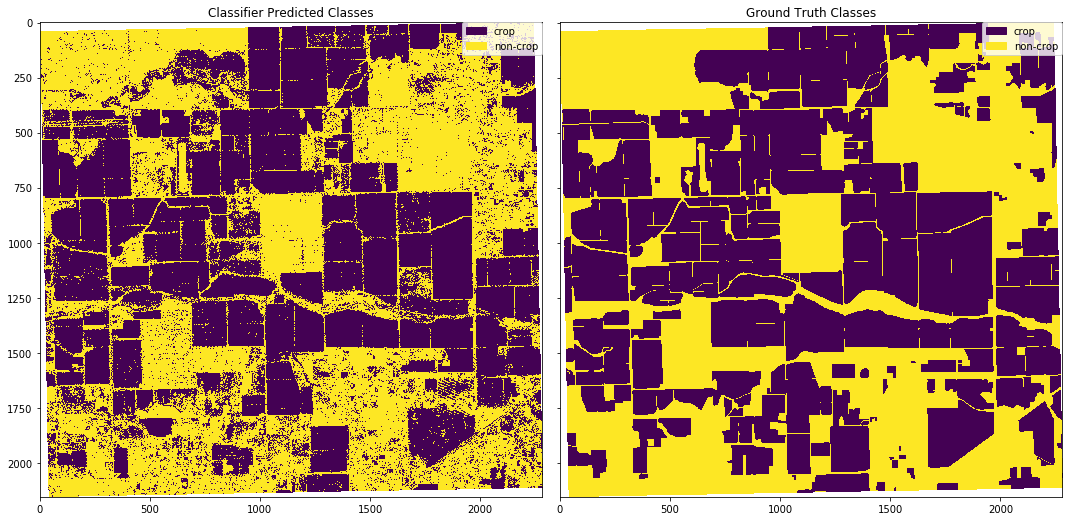

In [19]:
def imshow_class_band(ax, class_band):
    """Show classified band with legend. Alters ax in place."""
    im = ax.imshow(class_band)

    # https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
    colors = [ im.cmap(im.norm(value)) for value in (0,1)]
    labels = ('crop', 'non-crop')

    # https://matplotlib.org/users/legend_guide.html
    # tag: #creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
    patches = [mpatches.Patch(color=c, label=l) for c,l in zip(colors, labels)]
    
    ax.legend(handles=patches, bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.)

def plot_predicted_vs_truth(predicted_class_band, truth_class_band, figsize=(15,15)):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                   sharex=True, sharey=True,
                                   figsize=figsize)
    for ax in (ax1, ax2):
        ax.set_adjustable('box-forced')

    imshow_class_band(ax1, predicted_class_band)
    ax1.set_title('Classifier Predicted Classes')

    imshow_class_band(ax2, truth_class_band)
    ax2.set_title('Ground Truth Classes')
    plt.tight_layout()

plot_predicted_vs_truth(train_predicted_class_band,
                        create_contour_classified_band(train_pl_filename,
                                                       train_ground_truth_filename))

The predicted classes are close to the ground truth classes, but appear a little noisier and there are a few regions that are different.

The predicted classes are close to the ground truth classes, but appear a little noisier and there are a few regions that are different.

There is one instance where they disagree, the crop region in rows 1650-2150, columns 1500-2000.

In [20]:
# Utility functions: Comparing ground truth and actual in a region

def calculate_ndvi(bands):
    return (bands.nir.astype(np.float) - bands.r) / (bands.nir + bands.r)

def plot_region_compare(region_slice, predicted_class_band, class_band, img_bands):
    # x[1:10:5,::-1] is equivalent to 
    # obj = (slice(1,10,5), slice(None,None,-1)); x[obj]
    # https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                                                 figsize=(10,10))
    for ax in (ax1, ax2, ax3, ax4):
        ax.set_adjustable('box-forced')

    imshow_class_band(ax1, predicted_class_band[region_slice])
    ax1.set_title('Predicted Classes')
    
    imshow_class_band(ax2, class_band[region_slice])
    ax2.set_title('Ground Truth Classes')

    region_bands = NamedBands(*[b[region_slice] for b in img_bands])

    ax3.imshow(bands_to_display(get_rgb(region_bands)))
    ax3.set_title('Planet Scene RGB')

    ax4.imshow(bands_to_display(3*[calculate_ndvi(region_bands)], alpha=False))
    ax4.set_title('Planet Scene NDVI')
    
    plt.tight_layout()

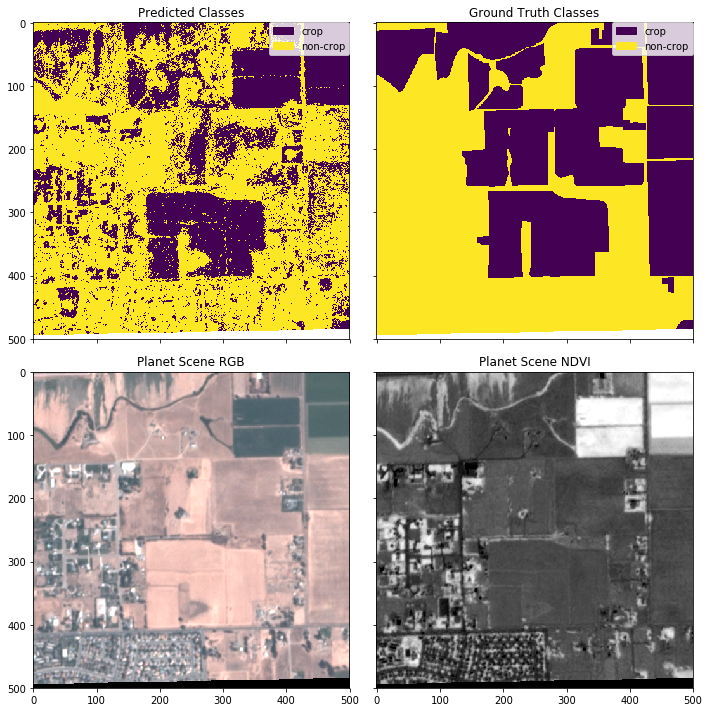

In [21]:
plot_region_compare((slice(1650,2150,None), slice(600,1100,None)),
                    train_predicted_class_band,
                    create_contour_classified_band(train_pl_filename,
                                                   train_ground_truth_filename),
                    load_refl_bands(train_pl_filename, train_pl_metadata_filename))

The classifier filters out the regions identified in the ground truth as 'crop' on the right side of this region. The region is brown in the RGB image and doesn't appear to be a crop. However, in the center of the region, the classifier agrees with the ground truth that this region, which appears light brown in RGB and dark in NDVI, is a 'crop'. It is unclear from visual inspection why this region is classified as a crop, and without ground truth data from the year the image was taken, it is hard to verify whether this classification is correct or not. However, it appears to be a misclassification due to errors in the ground truth data (ie the ground truth data indicates this is a 'crop' region while it is not) due to the time gap between when the ground truth data was collected and when the imagery was collected.

### Test Classifier

Use the KNN classifier trained on the training data to predict the crop regions in the test data.

First, let's check out a 'noisier' region. We will zoom into rows 600-1000, columns 200-600 to take a look.

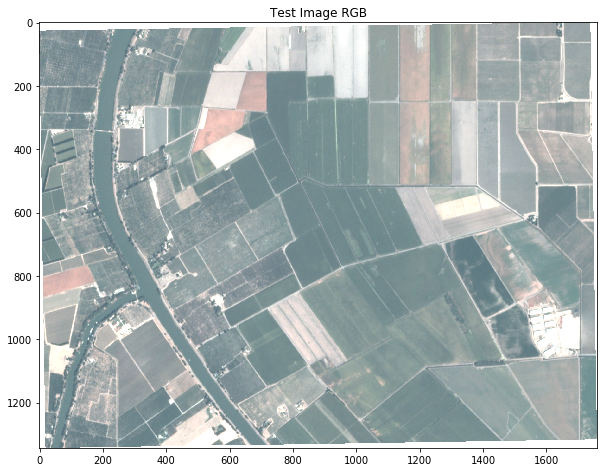

In [22]:
plt.figure(1, figsize=(10,10))
plt.imshow(bands_to_display(get_rgb(load_refl_bands(test_pl_filename, test_pl_metadata_filename)),
                            alpha=True))
_ = plt.title('Test Image RGB')

In [23]:
test_predicted_class_band = predict(test_pl_filename, test_pl_metadata_filename, clf)

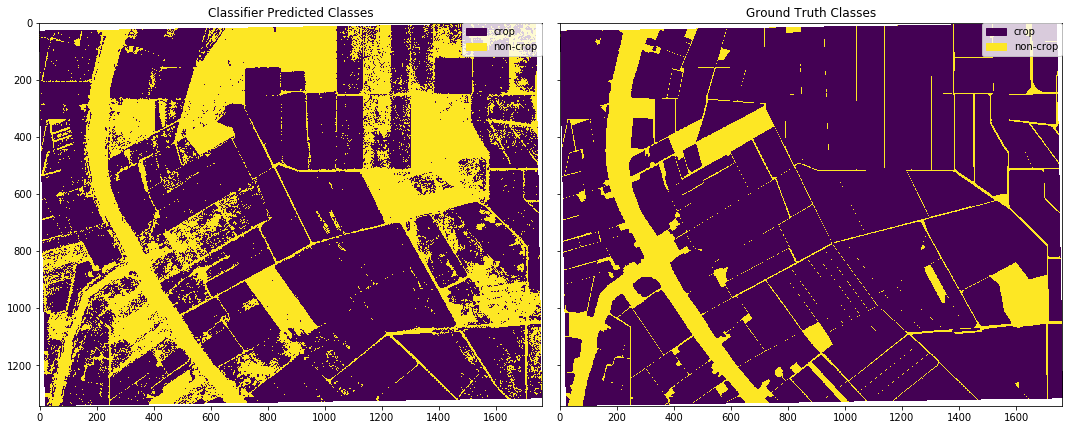

In [24]:
plot_predicted_vs_truth(test_predicted_class_band,
                        create_contour_classified_band(test_pl_filename,
                                                       test_ground_truth_filename))

The predicted classes are close to the ground truth classes, but appear a little noisier and there are a few regions that are different.

First, let's look a a noisier region.

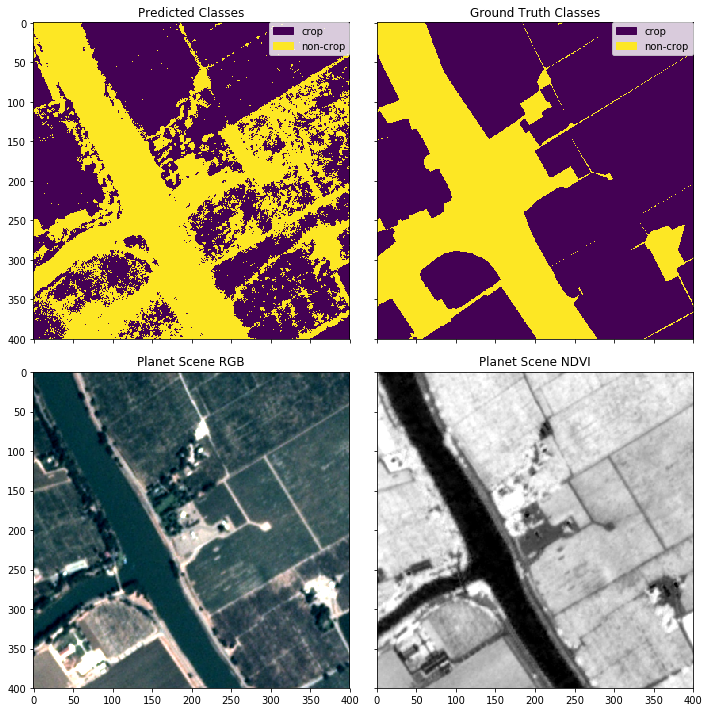

In [25]:
plot_region_compare((slice(600,1000,None), slice(200,600,None)),
                    test_predicted_class_band,
                    create_contour_classified_band(test_pl_filename,
                                                   test_ground_truth_filename),
                    load_refl_bands(test_pl_filename, test_pl_metadata_filename))

Ah! In this region, some of the 'noisier' appearance is actually due to the ground truth data being generalized a bit and missing some of the detail that the classified image is picking up. What is really cool is that the trees along the river are classified as 'non-crop' by the classifier, while the ground truth data classified the trees as 'crop' (possibly because the trees are shading the crop there).

However, there is some noise which is due to a misclassification of some of the crop pixels as 'non-crop' (lower-left, center-right regions). Hopefully segmentation will clean up these noisy regions.

Now let's check out a 'changed' region. This is a region that was marked as a non-crop region in the ground truth data, but is not predicted to be a crop by the KNN classifier. Lets zoom into rows 200-600, columns 400-800 to take a look.

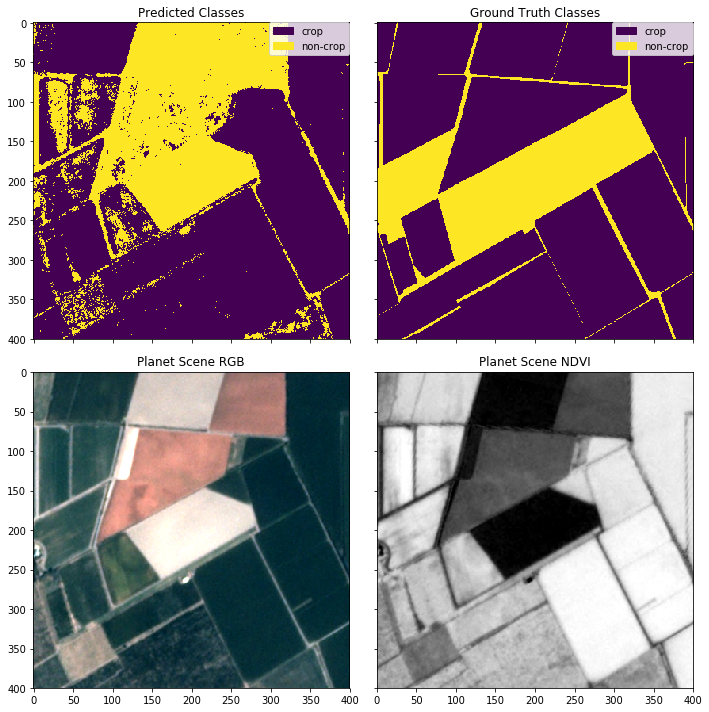

In [26]:
plot_region_compare((slice(200,600,None), slice(400,800,None)),
                    test_predicted_class_band,
                    create_contour_classified_band(test_pl_filename,
                                                   test_ground_truth_filename),
                    load_refl_bands(test_pl_filename, test_pl_metadata_filename))

Wow! In the Planet scene RGB and NDVI, we can see that the crop shape has changed between when the ground truth data was collected and when the Planet scene was collected (2-year gap). The class predicted by the KNN classifier is more accurate than the ground truth class.

### Classifier Accuracy Metric

Although the most informative way to determine the accuracy of the classification results is to compare the images of the predicted classes to the ground truth classes, this is subjective and can't be generalized. We will fall back on classic classification metrics and see if they match with our quantitative assessment.

scikit-learn provides a convenient function for calculating and reporting classification metrics, [`classification_report`](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-report). Using this, we will compare the classification metrics obtained with the train and the test datasets (in order).

In [27]:
# train dataset
print(classification_report(to_y(create_contour_classified_band(train_pl_filename,
                                          train_ground_truth_filename)),
                            to_y(train_predicted_class_band),
                            target_names=['crop', 'non-crop']))

             precision    recall  f1-score   support

       crop       0.89      0.86      0.87   2641217
   non-crop       0.83      0.86      0.85   2094510

avg / total       0.86      0.86      0.86   4735727



In [28]:
# test dataset
print(classification_report(to_y(create_contour_classified_band(test_pl_filename,
                                          test_ground_truth_filename)),
                            to_y(test_predicted_class_band),
                            target_names=['crop', 'non-crop']))

             precision    recall  f1-score   support

       crop       0.95      0.72      0.82   1962632
   non-crop       0.32      0.77      0.45    329716

avg / total       0.86      0.73      0.77   2292348



The ultimate goal of the classification of pixels is accurate segmentation of crop regions. This likely will require that each region have a majority of correctly classified pixels. Therefore, both precision and recall are important and the f1-score is a good metric for predicting accuracy. 

The f1-score does drop between the train and test datasets, but considering that the classifier was trained on the 'train' dataset, the drop is to be expected. An f1-score of 0.77 is promising and is adequate to try segmentation schemes on the classified data.

## Segmentation

We will perform segmentation on the test dataset classified by the trained KNN classifier.

In [29]:
# test_predicted_class_band.data
class_band = np.ma.array(test_predicted_class_band.astype(np.uint8), mask=test_predicted_class_band.mask)

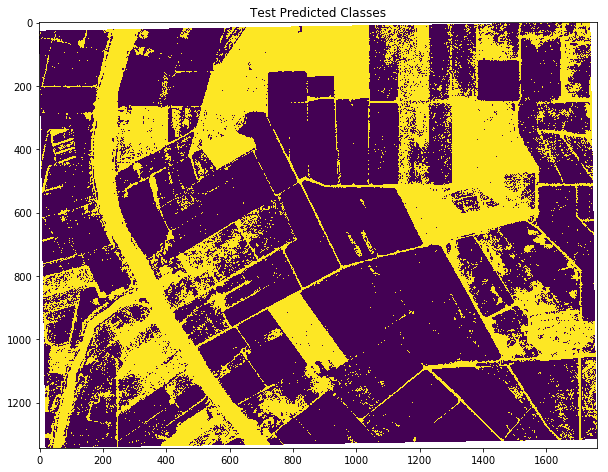

In [30]:
# class_band = np.ma.array(test_predicted_class_band.data.astype(np.uint8), mask=test_predicted_class_band.mask)
class_band = test_predicted_class_band.astype(np.uint8)

plt.figure(1, figsize=(10,10))
plt.imshow(class_band)
_ = plt.title('Test Predicted Classes')

#### Denoising

We first denoise the classified image by getting rid of any classified region smaller than 5x5 pixels (approximately 15m x 15m)

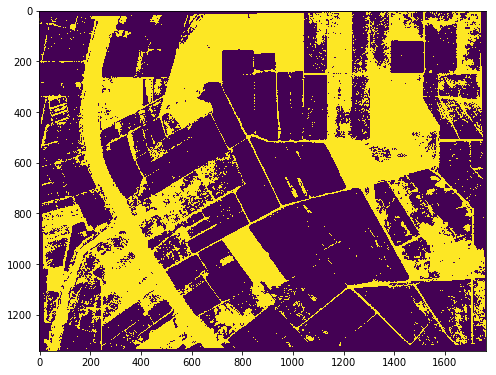

In [40]:
kernel = np.ones((3,3),np.uint8)
# denoised = cv2.morphologyEx(class_band, cv2.MORPH_OPEN, kernel)
denoised = cv2.morphologyEx(class_band, cv2.MORPH_CLOSE, kernel)

plt.figure(1, figsize=(8,8))
_ = plt.imshow(denoised)

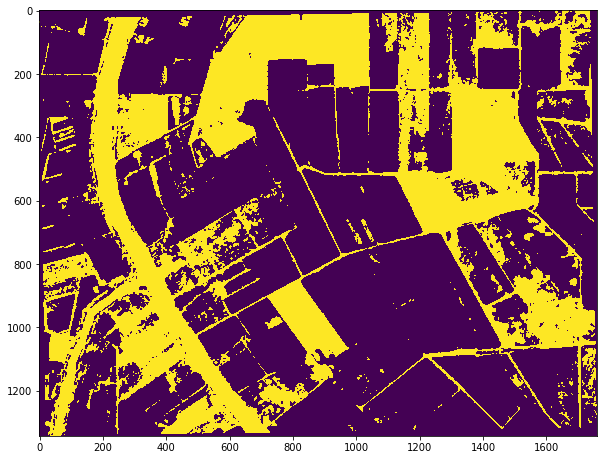

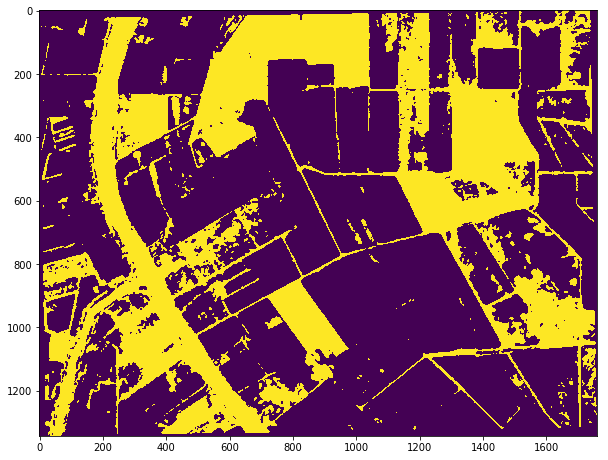

In [32]:
def denoise(img):
    denoised = cv2.medianBlur(class_band, 5)
    plt.figure(figsize=(10,10)); plt.imshow(denoised)

    denoised = cv2.medianBlur(denoised, 5)
    plt.figure(figsize=(10,10)); plt.imshow(denoised)
    
    return denoised

denoised = denoise(class_band)

#### Binary Segmentation

In [33]:
def denoise(img):
    denoised = cv2.medianBlur(class_band, 5)
#     plt.figure(figsize=(10,10)); plt.imshow(denoised)

    denoised = cv2.medianBlur(denoised, 5)
#     plt.figure(figsize=(10,10)); plt.imshow(denoised)
    
    return denoised


def to_crop_image(class_band):
    denoised = denoise(class_band)
    
    # crop pixels are 1, non-crop pixels are zero
    crop_image = np.zeros(denoised.shape, dtype=np.uint8)
    crop_image[(~class_band.mask) & (denoised == 0)] = 1
#     plt.figure(figsize=(10,10)); plt.imshow(crop_image)
    return crop_image

crop_image = to_crop_image(class_band)

In [34]:
def crop_contours(img):
    # http://docs.opencv.org/trunk/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a
    _, contours, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    def is_region(contour):
        num_points = contour.shape[0]
        return num_points >= 3
    
    def has_significant_area(contour):
        return cv2.contourArea(contour) >= 4

    return [c for c in contours
            if is_region(c)
            and has_significant_area(c)]

contours = crop_contours(crop_image)
print(len(contours))

670


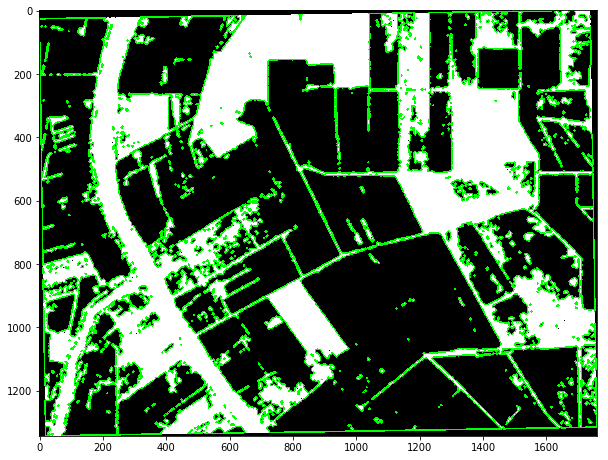

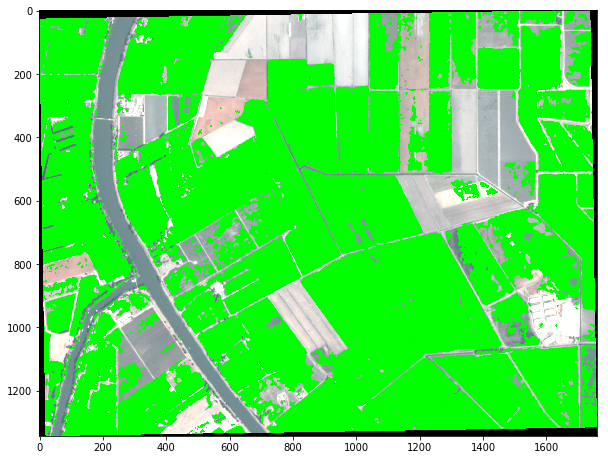

In [35]:
figsize = 10; plt.figure(figsize=(figsize,figsize))
plt.imshow(draw_contours(bands_to_display(3*[np.ma.array(denoised, mask=class_band.mask)], alpha=False),
                         contours,
                         thickness=4))

figsize = 10; plt.figure(figsize=(figsize,figsize))
plt.imshow(draw_contours(bands_to_display(get_rgb(load_refl_bands(test_pl_filename, test_pl_metadata_filename)),
                                          alpha=False),
                         contours,
                         thickness=-1))

In [36]:
# Utility functions: contours to features

def contour_to_polygon(contour, image_transform):
    """Convert an OpenCV contour to a geojson Polygon.
    
    image_transform is typically obtained from `img.transform` where 
    img is obtained from `rasterio.open()
    
    :param feature_geometry: the 'geometry' entry in a geojson feature
    :param rasterio.Affine image_transform: image transformation"""
    
    # get list of x and y coordinates from contour
    # contour: np.array(<list of points>, dtype=np.int32)
    # contour shape: (<number of points>, 1, 2)
    # point: (col, row)
    points_shape = contour.shape
    cols_rows = contour.reshape((points_shape[0],points_shape[2])).tolist()
    cols, rows = zip(*cols_rows) # inverse of zip
    
    # convert rows/cols to x/y
    offset = 'ul' # OpenCV: contour point [0,0] is the upper-left corner of pixel 0,0
    points_x, points_y = rasterio.transform.xy(image_transform, rows, cols, offset=offset)
    
    # create geometry from series of points
    points_xy = zip(points_x, points_y)
    return Polygon(points_xy)


def project_features_from_srs(features, img_srs, dst_srs='epsg:4326'):
    """Project features from img_srs.
    
    If dst_srs is not specified, WGS84 (only geojson-supported crs) is assumed.
    
    :param features: list of geojson features to be projected
    :param str img_srs: source spatial reference system
    :param str dst_srs: destination spatial reference system
    """
    # define projection
    # from shapely [docs](http://toblerity.org/shapely/manual.html#shapely.ops.transform)
    proj_fcn = partial(
        pyproj.transform,
        pyproj.Proj(init=img_srs),
        pyproj.Proj(init=dst_srs))
    
    return [project_feature(f, proj_fcn) for f in features]


# def polygons_to_features(polygons, pl_filename):
#     with rasterio.open(pl_filename) as img:
#         img_srs = img.crs['init']

#     def to_feature(polygon):
#         return {'type': 'Feature',
#                 'properties': {},
#                 'geometry': mapping(polygon)}
#     features = [to_feature(p) for p in polygons]
#     return project_features_from_srs(features, img_srs)

def polygon_to_feature(polygon):
    return {'type': 'Feature',
            'properties': {},
            'geometry': mapping(polygon)}    

def contours_to_features(contours, pl_filename):
    with rasterio.open(test_pl_filename) as img:
        img_srs = img.crs['init']
        img_transform = img.transform
        
    polygons = [contour_to_polygon(c, img_transform)
                for c in contours]

    simplified_polygons = [p.simplify(6, preserve_topology=False)
                           for p in polygons]
    def passes_filters(p):
        return p.area > (100 * 100)

    features = [polygon_to_feature(p)
                for p in simplified_polygons
                if passes_filters(p)]

    return project_features_from_srs(features, img_srs)

features = contours_to_features(contours, test_pl_filename)
print(len(features))

35


#### Visualize Features on Map

In [37]:
# Create crop feature layer
feature_collection = {
    "type": "FeatureCollection",
    "features": features,
    "properties": {"style":{
        'weight': 0,
        'fillColor': "blue",
        'fillOpacity': 1}}
}

feature_layer = ipyl.GeoJSON(data=feature_collection)

In [38]:
# Initialize map using parameters from above map
# and deleting map instance if it exists
try:
    del crop_map
except NameError:
    pass


zoom = 13
center = [38.30839, -121.55187] # lat/lon

In [39]:
# Create map, adding box drawing controls
# Reuse parameters if map already exists
try:
    center = crop_map.center
    zoom = crop_map.zoom
except NameError:
    pass

# Change tile layer to one that makes it easier to see crop features
# Layer selected using https://leaflet-extras.github.io/leaflet-providers/preview/
map_tiles = ipyl.TileLayer(url='http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png')
crop_map = ipyl.Map(
        center=center, 
        zoom=zoom,
        default_tiles = map_tiles
    )

crop_map.add_layer(feature_layer)  


# Display map
crop_map